# Antonio Alejo Module 7

For this project, I wanted to return to the Phoenix crime dataset that we looked at in Module 3. I was really intruiged by this dataset for a few reasons. First, this data is very relevant to me. Although I am not an Arizona or Phoenix native, I have called the area home for the past 3 years. I also wanted to revisit this dataset because of the large amount of data entries that it holds. The dataset also includes data based on location, and having variables such as when the crime occurred, which type of crime it was, and where it happened allow for a few different research questions to be asked. Completing module 3 also gave me an interest into the possible implications of this data and how certain findings can be used to predict and/or prevent crime.

## Research questions:

Do distinct patterns emerge regarding the prevalence of different crime types during the different seasons in Phoenix, Arizona?

Can we predict the nature of crimes, distinguishing between violent and nonviolent, in Phoenix based on their geographical location, specifically using zip codes as a predictor?

Which specific premises exhibit the highest association with different crime types in Phoenix?

## Literature Review:

Throughout my time in academia, there have been multiple times, usually in a statistics or psychology class, when an example of 'correlation does not equal causation' is brought up. An example that is commonly used is that when ice cream sales are high, crime rates are also high. This example is used to show that the purchasing of ice cream does not cause crime, but that both ice cream sales and crime rates are higher in the summer. The National Reeentry Resource Center's (2024) findings from the Bureau of Justice Statistics indicate that there is a higher rate of household property crimes in the summer. They also found that motor vehicle thefts do not have a seasonal pattern, violent assaults patterns vary depending on the crime, aggravated assault rates are highest in the summer, rape, sexual assault, and intimate partner violence rates are highest in the summer, and robbery rates do not have seasonal variations. While some crimes do not have a seasonal pattern, summer seems to be a common denominator for those crimes that do have a seasonal pattern. The reason why I would like to look into seasonal trends for crime in Phoenix is because of how hot it gets in the summer. One of the reasons why more crimes happen in the summer is because more people are outside. But does that hold true for summers in Phoenix, where people may be more inclined to stay in their houses because of the scorching heat?

In regards to my second research question, the location of where violent or nonviolent crimes occur in Phoenix can shed light on why and how these crimes are more likely to occur. This dataset includes different zip codes in the Phoenix area, usually belonging to different neighborhoods in the area and the greater Phoenix area as well. Although the dataset does not include the average income level of these zip codes, finding out where crime is more likely to occur and comparing that to income level can not only give good insight to the problem, but also allow for solutions to be made regarding crime. This is because individuals with family incomes of less than 15,000 dollars are more than three times as likely to be the victim of a crime as individuals with family incomes of more than 75,000 dollars (CASES, 2024). The most prevalent personal crimes for low-income victims tend to be violent as well (CASES, 2024), giving me some insight as to what to expect when trying to answer this question.

To relate to my last research question, security consultant Chris E. McGoey (2023) has found that properties open to the public generally operate at a greater crime risk. McGoey (2023) has also found that cash-based late-night businesses have greater crime risk. Since it is also more likely for low income areas to be more susceptible to crime, these areas most likely have less security for stores, homes, and apartment buildings as well, making them an easier target for criminals. 

In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
#import PHX crime data
crime = pd.read_csv(r"C:\Users\tonya\Downloads\crime-data_crime-data_crimestat.csv", engine = 'python')

In [3]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527580 entries, 0 to 527579
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   INC NUMBER          527580 non-null  object 
 1   OCCURRED ON         527161 non-null  object 
 2   OCCURRED TO         339743 non-null  object 
 3   UCR CRIME CATEGORY  527580 non-null  object 
 4   100 BLOCK ADDR      527580 non-null  object 
 5   ZIP                 527574 non-null  float64
 6   PREMISE TYPE        524070 non-null  object 
 7   GRID                526141 non-null  object 
dtypes: float64(1), object(7)
memory usage: 32.2+ MB


I will be removing some variables, as they will not be needed or used in this project. The variables being removed are 'INC NUMBER', 'OCCURRED TO', '100 BLOCK ADDR', and 'GRID'.

In [4]:
#drop the variables that will not be used
crime = crime.drop(['INC NUMBER', 'OCCURRED TO', '100 BLOCK ADDR', 'GRID'], axis = 1)

I also will not be using the time at which the crimes occurred. This information could be useful depending on the research question, but it is not relevant in mine. Since my research question requires seasonal information, a new variable will be made based on the month of the crime. For the sake of this project (and my sanity) I will group the seasons by months instead of the exact dates that the seasons starts (the solstices).

In [5]:
#remove time
crime['DATE'] = crime['OCCURRED ON'].str.split(' ').str[0]

#convert the 'DATE' column to a datetime object
crime['DATE'] = pd.to_datetime(crime['DATE'], format='%m/%d/%Y')

#a function is made to determine the season
def get_season(month):
    if 3 <= month <= 5:
        return 'SPRING'
    elif 6 <= month <= 8:
        return 'SUMMER'
    elif 9 <= month <= 11:
        return 'FALL'
    else:
        return 'WINTER'

#create a new 'season' column using the new function
crime['SEASON'] = crime['DATE'].dt.month.apply(get_season)

#the occurred on and date variables can be removed
crime = crime.drop(['OCCURRED ON', 'DATE'], axis = 1)

In [6]:
crime.head()

,UCR CRIME CATEGORY,ZIP,PREMISE TYPE,SEASON
0,RAPE,85006.0,SINGLE FAMILY HOUSE,FALL
1,LARCENY-THEFT,85014.0,APARTMENT,FALL
2,LARCENY-THEFT,85014.0,PARKING LOT,FALL
3,MOTOR VEHICLE THEFT,85043.0,SINGLE FAMILY HOUSE,FALL
4,MOTOR VEHICLE THEFT,85029.0,SINGLE FAMILY HOUSE,FALL


## Question 1:

In [7]:
crime['SEASON'].value_counts()

WINTER    140531
FALL      132027
SPRING    129085
SUMMER    125937
Name: SEASON, dtype: int64

Text(0, 0.5, 'Number of Crimes Reported')

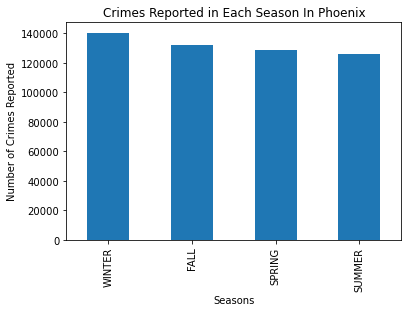

In [8]:
plt1 = crime['SEASON'].value_counts().plot.bar()
plt1.set_title('Crimes Reported in Each Season In Phoenix')
plt1.set_xlabel('Seasons')
plt1.set_ylabel('Number of Crimes Reported')

As we can see above, the most crimes reported in this dataset happened between December and February. This opposes general crime rate trends across the country, where more crime is likely to happen during the summer.

Earlier in my report, it was mentioned that violent crimes are more prevalent in the summer. Given the information that we are given above, lets look at the amount of different crimes for the different seasons and compare.

### Winter Crime Counts

In [9]:
#need to rename columns that have spaces because python syntax does not like spaces
crime = crime.rename(columns = {'UCR CRIME CATEGORY': 'CRIME_CATEGORY', 'PREMISE TYPE': 'PREMISE_TYPE'})

crime[crime['SEASON'] == 'WINTER'].CRIME_CATEGORY.value_counts()

LARCENY-THEFT                            74079
BURGLARY                                 18090
MOTOR VEHICLE THEFT                      15726
DRUG OFFENSE                             12038
AGGRAVATED ASSAULT                       11387
ROBBERY                                   5510
RAPE                                      2100
ARSON                                     1246
MURDER AND NON-NEGLIGENT MANSLAUGHTER      355
Name: CRIME_CATEGORY, dtype: int64

Text(0, 0.5, 'Number of Crimes Reported')

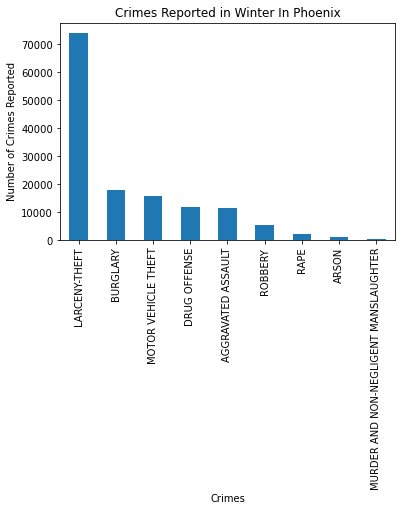

In [10]:
plt2 = crime[crime['SEASON'] == 'WINTER'].CRIME_CATEGORY.value_counts().plot.bar()
plt2.set_title('Crimes Reported in Winter In Phoenix')
plt2.set_xlabel('Crimes')
plt2.set_ylabel('Number of Crimes Reported')

### Fall Crime Counts

In [11]:
crime[crime['SEASON'] == 'FALL'].CRIME_CATEGORY.value_counts()

LARCENY-THEFT                            67154
BURGLARY                                 16708
MOTOR VEHICLE THEFT                      15536
AGGRAVATED ASSAULT                       12175
DRUG OFFENSE                             11704
ROBBERY                                   5299
RAPE                                      2034
ARSON                                     1091
MURDER AND NON-NEGLIGENT MANSLAUGHTER      326
Name: CRIME_CATEGORY, dtype: int64

Text(0, 0.5, 'Number of Crimes Reported')

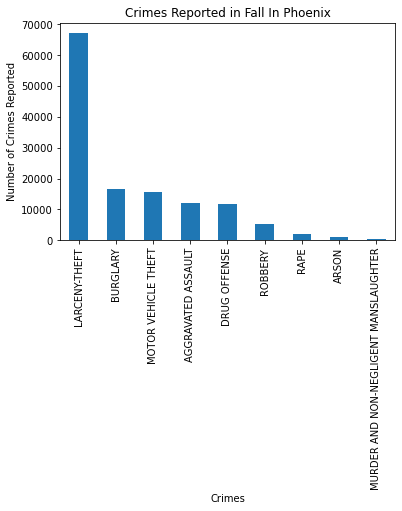

In [12]:
plt3 = crime[crime['SEASON'] == 'FALL'].CRIME_CATEGORY.value_counts().plot.bar()
plt3.set_title('Crimes Reported in Fall In Phoenix')
plt3.set_xlabel('Crimes')
plt3.set_ylabel('Number of Crimes Reported')

### Spring Crime Counts

In [13]:
crime[crime['SEASON'] == 'SPRING'].CRIME_CATEGORY.value_counts()

LARCENY-THEFT                            65375
BURGLARY                                 16649
MOTOR VEHICLE THEFT                      14067
DRUG OFFENSE                             12460
AGGRAVATED ASSAULT                       12080
ROBBERY                                   4890
RAPE                                      1956
ARSON                                     1266
MURDER AND NON-NEGLIGENT MANSLAUGHTER      342
Name: CRIME_CATEGORY, dtype: int64

Text(0, 0.5, 'Number of Crimes Reported')

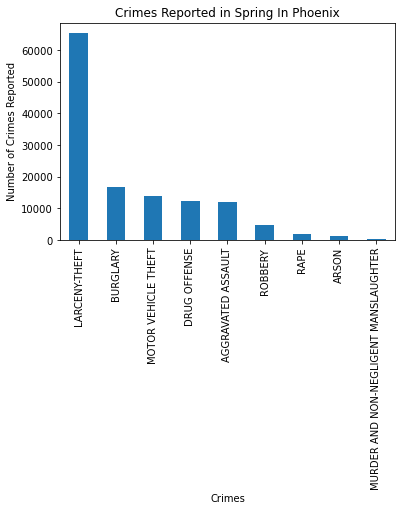

In [14]:
plt4 = crime[crime['SEASON'] == 'SPRING'].CRIME_CATEGORY.value_counts().plot.bar()
plt4.set_title('Crimes Reported in Spring In Phoenix')
plt4.set_xlabel('Crimes')
plt4.set_ylabel('Number of Crimes Reported')

### Summer Crime Counts

In [15]:
crime[crime['SEASON'] == 'SUMMER'].CRIME_CATEGORY.value_counts()

LARCENY-THEFT                            61840
BURGLARY                                 16213
MOTOR VEHICLE THEFT                      15115
AGGRAVATED ASSAULT                       12216
DRUG OFFENSE                             11841
ROBBERY                                   5053
RAPE                                      2049
ARSON                                     1274
MURDER AND NON-NEGLIGENT MANSLAUGHTER      336
Name: CRIME_CATEGORY, dtype: int64

Text(0, 0.5, 'Number of Crimes Reported')

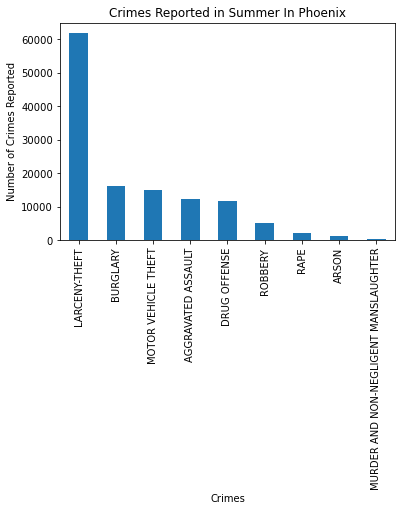

In [16]:
plt5 = crime[crime['SEASON'] == 'SUMMER'].CRIME_CATEGORY.value_counts().plot.bar()
plt5.set_title('Crimes Reported in Summer In Phoenix')
plt5.set_xlabel('Crimes')
plt5.set_ylabel('Number of Crimes Reported')

Comparing the numbers, the winter season saw more crime in most categories besides aggrevated assault and arson. Using this information and the considerations made in the literature review, more research can be done to understand the pattern here. I think it makes sense that the amount of arson that occurs and is reported is the highest in the summer - the climate in Phoenix is so hot and dry during the summer that it could make committing arson easier than the other seasons. As for the high aggrevated assault during Phoenix summers, some more theories investigating why this type of crime is higher in the summer can be made. This pattern does coincide with the existing literature, but more questions can be asked, perhaps to investigate the effects that scorching heat can have on aggressive tendencies. 

## Question 2:

To investigate the second research question, a Naive Bayes classifier will be implemented. First, a variable that indicates whether or not a crime is violent will be created. Larceny-theft, burglary, motor vehicle theft, and drug offense will be categorized as nonviolent. Aggrevated assault, robbery, rape, arson, and murder and non-negligent manslaughter will be categorized as violent.

In [17]:
#create a function to determine whether a crime is violent or not
def violent_or_not(crimetype):
    if crimetype['CRIME_CATEGORY'] == 'LARCENY-THEFT' or crimetype['CRIME_CATEGORY'] == 'BURGLARY' or crimetype['CRIME_CATEGORY'] == 'MOTOR VEHICLE THEFT' or crimetype['CRIME_CATEGORY'] == 'DRUG OFFENSE':
        return 'NONVIOLENT'
    else:
        return 'VIOLENT'

#add new variable to the dataset that implements the new function    
crime['TYPE'] = crime.apply(violent_or_not, axis=1)

#create a function similar to violent_or_not that gives a 0 for nonviolent and 1 for violent
def violent_or_not2(crimetype2):
    if crimetype2['TYPE'] == 'NONVIOLENT':
        return 0
    else:
        return 1

#again, create a new variable that implements the new function    
crime['V_or_N'] = crime.apply(violent_or_not2, axis=1)

In [18]:
crime.head()

,CRIME_CATEGORY,ZIP,PREMISE_TYPE,SEASON,TYPE,V_or_N
0,RAPE,85006.0,SINGLE FAMILY HOUSE,FALL,VIOLENT,1
1,LARCENY-THEFT,85014.0,APARTMENT,FALL,NONVIOLENT,0
2,LARCENY-THEFT,85014.0,PARKING LOT,FALL,NONVIOLENT,0
3,MOTOR VEHICLE THEFT,85043.0,SINGLE FAMILY HOUSE,FALL,NONVIOLENT,0
4,MOTOR VEHICLE THEFT,85029.0,SINGLE FAMILY HOUSE,FALL,NONVIOLENT,0


In [19]:
#create testing and training variables
X_train, X_test, y_train, y_test = train_test_split(crime['ZIP'].astype(str), crime['V_or_N'], 
                                                    test_size=0.2, random_state=1)

In [20]:
tfidf_vectorizer = TfidfVectorizer(use_idf = True)
X_train_tf = tfidf_vectorizer.fit_transform(X_train)
X_test_tf = tfidf_vectorizer.transform(X_test)

In [21]:
#create the model
nb = MultinomialNB()
nb.fit(X_train_tf, y_train)

MultinomialNB()

In [22]:
#use the model to make predictions from our training and testing data
predictions = nb.predict(X_test_tf)

In [23]:
#get the accuracy of the model
accuracy = accuracy_score(y_test, predictions)

# Print the results
print(f'Accuracy: {accuracy}')

Accuracy: 0.8425072974714736


The Naive Bayes model correctly predicted whether a crime was violent or not based on zip code with an accuracy of 0.8425072974714736. This can be useful for a number of reasons. First, a similar model can be done with more data from a longer period of time. A similar model may also be implemented to not only predict where violent crime is more likely to occur, but predict when the crime will occur and which kind of crime it may be. This would possibly allow crimes to be stopped before they happen, by increasing surveillance in certain areas or by developing certain communities where crime is more likely to occur because, as was noted before, lower income levels are linked with higher crime rates.

## Question 3:

For my final research question, I will first be examining which types of premises in the dataset had the most crimes reported.

In [24]:
crime['PREMISE_TYPE'].value_counts()

SINGLE FAMILY HOUSE                    75852
APARTMENT                              70748
PARKING LOT                            44069
STREET / ROADWAY / SIDEWALK            30080
STREET / ROADWAY / ALLEY / SIDEWALK    28574
                                       ...  
REST AREA                                 15
STOREROOM / SHED                          14
LAKE / WATERWAY / BEACH                    8
MILITARY INSTALLATION                      6
TRIBAL LANDS                               5
Name: PREMISE_TYPE, Length: 98, dtype: int64

As we can see, the most crimes were reported to have occurred in/to a single family household. This makes sense, as this type of premise is of the most common in the city and the greater Phoenix area. A single family house is most likely to have valuables stored for criminals looking to commit nonviolent crime. A family house may also be vacant for many hours of the day, as many homeowners probably go to work for most of the day and perhaps have children that are at school for most of the day. A vacant house that may have less security could be an easier target for criminals. Relating to something that was pointed out earlier, crime is more likely to happen in areas that are open to the public. This is shown here, as many apartment buildings may not have security measures, especially in areas where crime is more likely to occur. Parking lots, streets, roadways, and sidewalks are also generally open to the public at all times as well, and crime may be committed on premises like these at any time of the day, especially with a lack of security.

Next, I will examine the different types of crimes that happen on some of these premises and see if there is any pattern.

### Single Family House Crimes Counts

In [25]:
crime[crime['PREMISE_TYPE'] == 'SINGLE FAMILY HOUSE'].CRIME_CATEGORY.value_counts()

BURGLARY                                 28431
LARCENY-THEFT                            25185
AGGRAVATED ASSAULT                        9198
MOTOR VEHICLE THEFT                       6931
RAPE                                      2367
DRUG OFFENSE                              2263
ROBBERY                                    726
ARSON                                      506
MURDER AND NON-NEGLIGENT MANSLAUGHTER      245
Name: CRIME_CATEGORY, dtype: int64

Text(0, 0.5, 'Number of Crimes Reported')

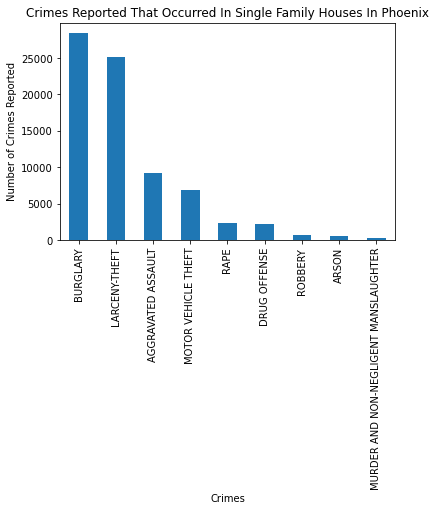

In [26]:
plt6 = crime[crime['PREMISE_TYPE'] == 'SINGLE FAMILY HOUSE'].CRIME_CATEGORY.value_counts().plot.bar()
plt6.set_title('Crimes Reported That Occurred In Single Family Houses In Phoenix')
plt6.set_xlabel('Crimes')
plt6.set_ylabel('Number of Crimes Reported')

### Apartment Crime Counts

In [27]:
crime[crime['PREMISE_TYPE'] == 'APARTMENT'].CRIME_CATEGORY.value_counts()

LARCENY-THEFT                            25920
MOTOR VEHICLE THEFT                      13907
BURGLARY                                 12649
AGGRAVATED ASSAULT                       11998
DRUG OFFENSE                              2500
RAPE                                      2076
ROBBERY                                   1185
ARSON                                      271
MURDER AND NON-NEGLIGENT MANSLAUGHTER      242
Name: CRIME_CATEGORY, dtype: int64

Text(0, 0.5, 'Number of Crimes Reported')

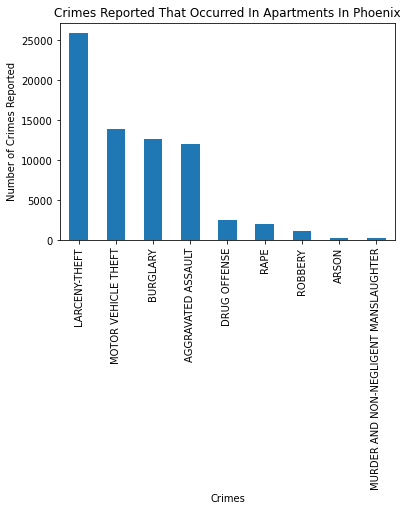

In [28]:
plt7 = crime[crime['PREMISE_TYPE'] == 'APARTMENT'].CRIME_CATEGORY.value_counts().plot.bar()
plt7.set_title('Crimes Reported That Occurred In Apartments In Phoenix')
plt7.set_xlabel('Crimes')
plt7.set_ylabel('Number of Crimes Reported')

### Parking Lot Crime Counts

In [29]:
crime[crime['PREMISE_TYPE'] == 'PARKING LOT'].CRIME_CATEGORY.value_counts()

LARCENY-THEFT                            23615
MOTOR VEHICLE THEFT                       8181
DRUG OFFENSE                              6946
ROBBERY                                   3152
AGGRAVATED ASSAULT                        1387
ARSON                                      228
RAPE                                       204
MURDER AND NON-NEGLIGENT MANSLAUGHTER      194
BURGLARY                                   162
Name: CRIME_CATEGORY, dtype: int64

Text(0, 0.5, 'Number of Crimes Reported')

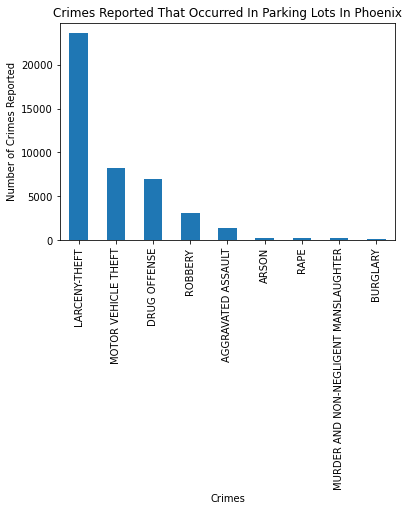

In [30]:
plt8 = crime[crime['PREMISE_TYPE'] == 'PARKING LOT'].CRIME_CATEGORY.value_counts().plot.bar()
plt8.set_title('Crimes Reported That Occurred In Parking Lots In Phoenix')
plt8.set_xlabel('Crimes')
plt8.set_ylabel('Number of Crimes Reported')

### Street, Roadway, Sidewalk Crime Counts

In [31]:
crime[crime['PREMISE_TYPE'] == 'STREET / ROADWAY / SIDEWALK'].CRIME_CATEGORY.value_counts()

LARCENY-THEFT                            9873
MOTOR VEHICLE THEFT                      6449
AGGRAVATED ASSAULT                       5930
DRUG OFFENSE                             5628
ROBBERY                                  1780
MURDER AND NON-NEGLIGENT MANSLAUGHTER     173
RAPE                                      131
ARSON                                      99
BURGLARY                                   17
Name: CRIME_CATEGORY, dtype: int64

Text(0, 0.5, 'Number of Crimes Reported')

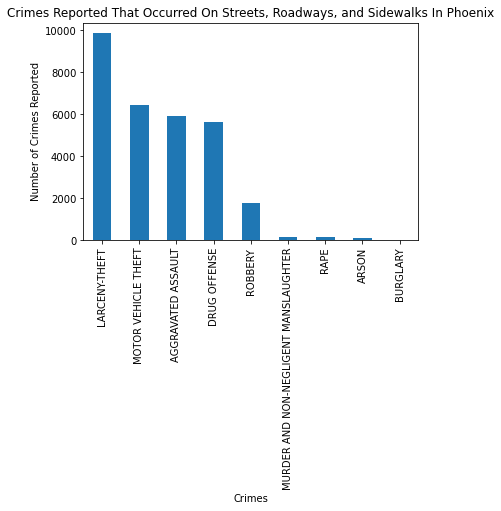

In [32]:
plt9 = crime[crime['PREMISE_TYPE'] == 'STREET / ROADWAY / SIDEWALK'].CRIME_CATEGORY.value_counts().plot.bar()
plt9.set_title('Crimes Reported That Occurred On Streets, Roadways, and Sidewalks In Phoenix')
plt9.set_xlabel('Crimes')
plt9.set_ylabel('Number of Crimes Reported')

Larceny-theft is the crime that occurs the most in these four different premise types besides single family homes. The crime that occurred most in a single family home was burglary. As I mentioned before, a single family house will tend to have more valuable items that a criminal would want to steal, causing a criminal to need to break into a home to commit this crime. Motor vehicle theft is also common amongst apartment buildings, parking lots, and streets. I believe that this makes sense, as motor vehicles are likely to be outside for these types of premises. This would allow a criminal to snoop around these premises, looking for vehicles that have not been locked or have valuable items inside. This data and analysis, consumed by a police force or someone looking to not have crimes committed against them, can be used as valuable information as to what to look out for so that they can prevent crime.

## Final Thoughts:

Some of the findings present in this report coincide with the current understanding of crime rates and how/why crime is more likely to occur. I found it interesting how my hunch that less crime may occur during the schorching hot summers of Phoenix was backed by this data. Although this data does not tell the whole story, it allows for more research questions to be asked. This will allow more expansive data to be collected, which will expand our knowledge of crime in the region. These findings and their implications can help law enforcement crack down on crime. However, that really begs the question of 'does more law enforcement prevent crime?'. This has been a somewhat polarizing question in the past few years, with many believing that law enforcement should be defunded or outright abolished. A recent study on this topic indicated that 10 to 17 new cops would need to be hired to save one more life a year in some areas (Rosalsky, 2021). This study only looked into one type of violent crime, that being homicide. I believe that this indicates that there is much more a grey area as to why crime happens and how to prevent it. As was mentioned multiple times earlier, areas with lower income are more likely to experience higher crime rates. While I do think increases surveillance could help prevent crime and catch the criminals that commit these crimes, programs and services should be implemented to build up these communities, instead of just purely adding more law enforcement.

### References:

CASES (2024). *Neighborhood-based Services*. https://www.cases.org/neighborhood-based/#:~:text=1%20Income%20also%20plays%20a,low%2Dincome%20victims%20are%20violent. 

McGoey, C.E. (2023). Crime Doctor. *Crime Risk Factor – Nature of the Premises*. https://crimedoctor.com/crime-risk-factor-nature-of-the-premises/

National Reeentry Resource Center (2024). *Seasonal Patterns in Criminal Victimization Trends*. https://nationalreentryresourcecenter.org/resources/seasonal-patterns-criminal-victimization-trends#:~:text=Aggravated%20assault%20rates%20are%20highest,do%20not%20have%20seasonal%20variations.

Rosalsky, G. (2021). NPR. *When You Add More Police To A City, What Happens?* https://www.npr.org/sections/money/2021/04/20/988769793/when-you-add-more-police-to-a-city-what-happens